In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from flax import struct
from flax.training import train_state
from clu import metrics
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [9]:
def flatten_batch(x: jnp.ndarray):
    assert len(x.shape) >= 2
    return x.reshape(-1, x.shape[-1])

def unsqueeze(x: jnp.ndarray, axis: int):
    return jnp.expand_dims(x, axis=axis)

def squeeze(x: jnp.ndarray, axis: int):
    return jnp.squeeze(x, axis=axis)

def sb_multi(a: jnp.ndarray, b: jnp.ndarray) -> jnp.ndarray:
    """ Perform matrix-vector multiplication for a single matrix/vector and each matrix/vector in a batch.
    """
    return jax.vmap(lambda x, y: jnp.dot(x, y), in_axes=(None, 0), out_axes=0)(a, b)

def bb_multi(a: jnp.ndarray, b: jnp.ndarray) -> jnp.ndarray:
    """ Perform matrix_vector multiplication for each pair of matrix/vector and matrix/vector in two batches.
    """
    return jax.vmap(lambda x, y: jnp.dot(x, y), in_axes=(0, 0), out_axes=0)(a, b)

def get_time_discretization(end_time: float, num_steps: int) -> tuple:
    dts = jnp.array([end_time / num_steps] * num_steps)
    ts = jnp.linspace(0.0, end_time, num_steps + 1)
    return (dts, ts)

def get_network_output(module: nn.Module, params: dict, x: jnp.ndarray, t: float) -> jnp.ndarray:
    assert len(x.shape) == 2                            # (B, d)
    t_batch = jnp.tile(t, reps=(x.shape[0], 1))         # (B, 1)
    x = jnp.concatenate([x, t_batch], axis=-1)          # (B, d+1)
    return module.apply({'params': params}, x)          # (B, d)

@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module: nn.Module, rng: jnp.ndarray, learning_rate: float, input_shape: tuple) -> TrainState:
    params = module.init(rng, jnp.zeros(shape=input_shape))['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        tx=tx,
        metrics=Metrics.empty()
    )

class DiffusionBridge:
    def __init__(self,
                 drift: callable,
                 diffusion: callable,
                 dim: int,
                 end_time: float,
                 num_steps: int,
                 true_score_transition: callable=None,
                 true_score_h: callable=None,
                 rng: jax.random.PRNGKey=jax.random.PRNGKey(321)):
        self.f = drift
        self.g = diffusion
        self.Sigma = lambda x, t: jnp.dot(self.g(x, t), self.g(x, t).T)
        self.inv_Sigma = lambda x, t: jnp.linalg.inv(self.Sigma(x, t))
        self.div_Sigma = lambda x, t: jnp.trace(jax.jacfwd(self.Sigma)(x, t))
        self.d = dim
        self.T = end_time
        self.N = num_steps
        self.dts, self.ts = get_time_discretization(self.T, self.N)
        self.rng = rng
        self.true_score_transition = true_score_transition
        self.true_score_h = true_score_h

    def simulate_forward_process(self, 
                                 initial_condition: jnp.ndarray) -> jnp.ndarray:
        """ Simulate the forward non-bridge process (X(t)):
            dX(t) = f(X(t), t) dt + g(X(t), t) dW(t)

        Args:
            initial_condition (jnp.ndarray): X(0) 

        Returns:
            jnp.ndarray: (B, N+1, d) forward non-bridge trajectories
        """        
        assert initial_condition.shape[-1] == self.d
        B = initial_condition.shape[0]      # batch size
        X = initial_condition.copy()
        trajectories = jnp.zeros(shape=(B, self.N + 1, self.d))
        trajectories = trajectories.at[:, 0, :].set(X)
        for t_idx in jnp.arange(self.N):
            t = self.ts[t_idx+1]
            dt = self.dts[t_idx]
            self.rng, _ = jax.random.split(self.rng)
            drift = dt * self.f(X, t) 
            diffusion = jnp.sqrt(dt) * sb_multi(self.g(X, t), jax.random.normal(self.rng, shape=(B, self.d)))
            X = X + drift + diffusion       # Euler-Maruyama
            trajectories = trajectories.at[:, t_idx + 1, :].set(X)
        return trajectories
    
    def simulate_backward_bridge(self, 
                                 score_transition_net: nn.Module, 
                                 score_transition_net_params: dict, 
                                 initial_condition: jnp.ndarray, 
                                 terminal_condition: jnp.ndarray, 
                                 using_true_score: bool) -> jnp.ndarray:
        """ Simulate the backward bridge process (Z*(t)):
            dZ*(t) = {f(T-t, Z*(t)) + Sigma(T-t, Z*(t)) s(T-t, Z*(t)) + div Sigma(T-t, Z*(t))} dt + g(T-t, Z*(t)) dW(t)

        Args:
            score_transition_net (nn.Module): s_{theta}(t, x)
            score_transition_net_params (dict): s_{theta}(t, x) parameters
            initial_condition (jnp.ndarray): Z*(0) = X(T-t)
            terminal_condition (jnp.ndarray): Z*(T) = X(0)
            using_true_score (bool): If True, use the predefined score transition function.

        Returns:
            jnp.ndarray: (B, N+1, d) backward bridge trajectories
        """        
        assert initial_condition.shape[-1] == terminal_condition.shape[-1] == self.d
        if using_true_score:
            assert self.true_score_transition is not None
        B = initial_condition.shape[0]      # batch size
        Z = initial_condition.copy()
        X = terminal_condition.copy()
        trajectories = jnp.zeros(shape=(B, self.N + 1, self.d))
        trajectories = trajectories.at[:, self.N, :].set(Z)
        for reverse_t_idx in jnp.arange(1, self.N)[::-1]:
            reverse_t = self.ts[reverse_t_idx]
            dt = self.dts[reverse_t_idx]
            self.rng, _ = jax.random.split(self.rng)
            if using_true_score:
                score_transition = self.true_score_transition(Z, X, reverse_t)
            else:
                score_transition = get_network_output(score_transition_net, 
                                                      score_transition_net_params, 
                                                      x=Z, 
                                                      t=reverse_t)
            drift = (-self.f(Z, reverse_t) + sb_multi(self.Sigma(Z, reverse_t), score_transition) + self.div_Sigma(Z, reverse_t)) * dt
            diffusion = jnp.sqrt(dt) * sb_multi(self.g(Z, reverse_t), jax.random.normal(self.rng, shape=(B, self.d)))
            Z = Z + drift + diffusion       # Euler-Maruyama
            trajectories = trajectories.at[:, reverse_t_idx, :].set(Z)
        trajectories = trajectories.at[:, 0, :].set(X)      # end point constraint
        return trajectories
    
    def simulate_forward_bridge(self, 
                                score_transition_net: nn.Module, 
                                score_transition_params: dict, 
                                score_marginal_net: nn.Module, 
                                score_marginal_params: dict, 
                                initial_condition: jnp.ndarray, 
                                terminal_condition: jnp.ndarray, 
                                using_true_score: bool) -> jnp.ndarray:
        """ Simulate the forward bridge process (X*(t)):

        Args:
            score_transition_net (nn.Module): s_{theta}(t, x)
            score_transition_params (dict): s_{theta}(t, x) parameters
            score_marginal_net (nn.Module): s*_{theta}(t, x)
            score_marginal_params (dict): s*_{theta}(t, x) parameters
            initial_condition (jnp.ndarray): X*(0)
            terminal_condition (jnp.ndarray): X*(T)
            using_true_score (bool): If True, use the predefined score h function.

        Returns:
            jnp.ndarray: (B, N+1, d) forward bridge trajectories
        """        
        assert initial_condition.shape[-1] == terminal_condition.shape[-1] == self.d
        if using_true_score:
            assert self.true_score_h is not None

        B = initial_condition.shape[0]      # batch size
        X = initial_condition.copy()
        Z = terminal_condition.copy()
        trajectories = jnp.zeros(shape=(B, self.N + 1, self.d))
        trajectories = trajectories.at[:, 0, :].set(X)
        for t_idx in jnp.arange(1, self.N):
            t = self.ts[t_idx]
            dt = self.dts[t_idx]
            self.rng, _ = jax.random.split(self.rng)
            if using_true_score:
                score_h = self.true_score_h(X, Z, t, self.T)
            else:
                score_transition = get_network_output(score_transition_net,
                                                    score_transition_params,
                                                    x=X,
                                                    t=t)
                score_marginal = get_network_output(score_marginal_net,
                                                    score_marginal_params,
                                                    x=X,
                                                    t=t)
                score_h = score_marginal - score_transition

            drift = (self.f(X, t) + sb_multi(self.Sigma(X, t), score_h) + self.div_Sigma(X, t)) * dt
            diffusion =jnp.sqrt(dt) * sb_multi(self.g(X, t), jax.random.normal(self.rng, shape=(B, self.d)))
            X = X + drift + diffusion
            trajectories = trajectories.at[:, t_idx, :].set(X)
        trajectories = trajectories.at[:, self.N, :].set(Z)      # end point constraint
        return trajectories
    
    def get_transition_gradient(self,
                                foward_trajectories: jnp.ndarray) -> jnp.ndarray:
        """ Compute g(t_{m-1}, X_{m-1}, t_m, X_m) for eq. (8)

        Args:
            foward_trajectories (jnp.ndarray): (B, N+1, d) forward non-bridge trajectories

        Returns:
            jnp.ndarray: (B, N, d) g(t_{m-1}, X_{m-1}, t_m, X_m)
        """        
        assert foward_trajectories.shape[-1] == self.d
        B = foward_trajectories.shape[0]      # batch size
        gradients = jnp.zeros(shape=(B, self.N, self.d))
        for t_idx in jnp.arange(1, self.N+1):
            X_m_minus_1 = foward_trajectories[:, t_idx-1, :]       # previous step for forward process
            X_m = foward_trajectories[:, t_idx, :]                 # current step for forward process
            dt = self.dts[t_idx-1]
            t_m_minus_1 = self.ts[t_idx-1]
            gradient = -(X_m - X_m_minus_1 - dt * self.f(X_m_minus_1, t_m_minus_1)) / dt
            gradient = sb_multi(self.inv_Sigma(X_m_minus_1, t_m_minus_1), gradient)
            gradients = gradients.at[:, t_idx-1, :].set(gradient)
        return gradients
    
    def get_marginal_gradient(self,
                              backward_trajectories: jnp.ndarray) -> jnp.ndarray:
        """ Compute g^(t_{m-1}, Z*_{m-1}, t_m, Z*_m) for eq. (18)

        Args:
            backward_trajectories (jnp.ndarray): (B, N+1, d) backward bridge trajectories

        Returns:
            jnp.ndarray: (B, N, d) g^(t_{m-1}, Z*_{m-1}, t_m, Z*_m)
        """        
        assert backward_trajectories.shape[-1] == self.d
        B = backward_trajectories.shape[0]      # batch size
        gradients = jnp.zeros(shape=(B, self.N, self.d))
        for reverse_t_idx in jnp.arange(1, self.N)[::-1]:       
            Z_m_minus_1 = backward_trajectories[:, reverse_t_idx+1, :]   # previous step for backward prcess, i.e. next step for forward process 
            Z_m = backward_trajectories[:, reverse_t_idx, :]             # current step for backward process, also for the forward process
            dt = self.dts[reverse_t_idx+1]
            reverse_t_m_minus_1 = self.ts[reverse_t_idx+1]
            gradient = -(Z_m - Z_m_minus_1 - dt * self.f(Z_m_minus_1, reverse_t_m_minus_1)) / dt
            gradient = sb_multi(self.inv_Sigma(Z_m_minus_1, reverse_t_m_minus_1), gradient)
            gradients = gradients.at[:, reverse_t_idx+1, :].set(gradient)
        return gradients
    
    def get_trajectories_generator(self,
                                   batch_size: int,
                                   process_type: str,
                                   initial_condition: jnp.ndarray,
                                   terminal_condition: jnp.ndarray,
                                   score_transition_net: nn.Module=None,
                                   score_transition_params: dict=None,
                                   score_marginal_net: nn.Module=None,
                                   score_marginal_params: dict=None,
                                   using_true_score: bool=True) -> callable:
        assert process_type in ['forward', 'backward_bridge', 'forward_bridge']
        assert initial_condition.shape[-1] == self.d
        def generator():
            initial_conditions = jnp.tile(initial_condition, reps=(batch_size, 1))
            terminal_conditions = jnp.tile(terminal_condition, reps=(batch_size, 1)) if terminal_condition is not None else None
            while True:
                if process_type == 'forward':
                    trajectories = self.simulate_forward_process(initial_conditions)
                elif process_type == 'backward_bridge':
                    if not using_true_score:
                        assert terminal_condition is not None
                        assert score_transition_net is not None
                        assert score_transition_params is not None
                    else:
                        assert self.true_score_transition is not None
                    trajectories = self.simulate_backward_bridge(score_transition_net, 
                                                                 score_transition_params, 
                                                                 initial_conditions, 
                                                                 terminal_conditions, 
                                                                 using_true_score)
                elif process_type == 'forward_bridge':
                    if not using_true_score:
                        assert terminal_condition is not None
                        assert score_transition_net is not None
                        assert score_transition_params is not None
                        assert score_marginal_net is not None
                        assert score_marginal_params is not None
                    else:
                        assert self.true_score_transition is not None
                    trajectories = self.simulate_forward_bridge(score_transition_net, 
                                                                score_transition_params, 
                                                                score_marginal_net, 
                                                                score_marginal_params, 
                                                                initial_conditions, 
                                                                terminal_conditions, 
                                                                using_true_score)
                yield trajectories
        return generator
        
    def learn_forward_transition_score(self,
                                       score_transition_net: nn.Module,
                                       initial_condition: jnp.ndarray,
                                       training_params: dict):
        data_generator = self.get_trajectories_generator(batch_size=training_params["batch_size"],
                                                         process_type='forward',
                                                         initial_condition=initial_condition,
                                                         terminal_condition=None,
                                                         score_transition_net=None,
                                                         score_transition_params=None,
                                                         score_marginal_net=None,
                                                         score_marginal_params=None,
                                                         using_true_score=False)
        dataset = tf.data.Dataset.from_generator(data_generator, output_types=(tf.float32), output_shapes=((training_params["batch_size"], self.N+1, self.d)))
        dataset = iter(tfds.as_numpy(dataset))

        @jax.jit
        def train_step(state: TrainState, batch_trajectories: jnp.ndarray):
            batch_ts = flatten_batch(unsqueeze(jnp.tile(self.ts[1:], reps=(training_params["batch_size"], 1)), axis=-1))        # (B*N, 1)
            score_transition_gradients = self.get_transition_gradient(batch_trajectories)                                       # (B, N, d)
            score_transition_gradients = flatten_batch(score_transition_gradients)                                              # (B*N, d)
            batch_trajectories = flatten_batch(batch_trajectories[:, 1:, :])                                                    # (B*N, d)
            batch = jnp.concatenate([batch_trajectories, batch_ts], axis=-1)                                                    # (B*N, d+1)
            def loss_fn(params):
                score_transition_est = state.apply_fn({'params': params}, batch)                                                # (B*N, d)
                loss = jnp.mean(jnp.square((score_transition_est - score_transition_gradients)))                       
                return loss
            grad_fn = jax.grad(loss_fn)
            grads = grad_fn(state.params)
            state = state.apply_gradients(grads=grads)

            loss = loss_fn(state.params)
            metric_updates = state.metrics.single_from_model_output(loss=loss)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state
        
        state = create_train_state(score_transition_net, self.rng, training_params["learning_rate"], (training_params["batch_size"], self.d+1))
        for i in range(training_params["num_epochs"]):

            for j in range(training_params["num_batches_per_epoch"]):
                batch_trajectories = next(dataset)
                state = train_step(state, batch_trajectories)
            print(f"Epoch {i} / {training_params['num_epochs']}: loss = {state.metrics.compute()['loss']:.4f}")
            state = state.replace(metrics=state.metrics.empty())

        return state.params

    def learn_marginal_score(self,
                             score_marginal_net: nn.Module,
                             initial_condition: jnp.ndarray,
                             terminal_condition: jnp.ndarray,
                             score_transition_net: nn.Module,
                             score_transition_params: dict,
                             training_params: dict):
        data_generator = self.get_trajectories_generator(batch_size=training_params["batch_size"],
                                                         process_type='backward_bridge',
                                                         initial_condition=initial_condition,
                                                         terminal_condition=terminal_condition,
                                                         score_transition_net=score_transition_net,
                                                         score_transition_params=score_transition_params,
                                                         score_marginal_net=None,
                                                         score_marginal_params=None,
                                                         using_true_score=False)
        dataset = tf.data.Dataset.from_generator(data_generator, output_types=(tf.float32), output_shapes=((training_params["batch_size"], self.N+1, self.d)))
        dataset = iter(tfds.as_numpy(dataset))

        @jax.jit
        def train_step(state: TrainState, batch_trajectories: jnp.ndarray):
            batch_ts = flatten_batch(unsqueeze(jnp.tile(self.ts[:-1], reps=(training_params["batch_size"], 1)), axis=-1))        # (B*N, 1)
            score_marginal_gradients = self.get_marginal_gradient(batch_trajectories)                                             # (B, N, d)
            score_marginal_gradients = flatten_batch(score_marginal_gradients)                                                    # (B*N, d)
            batch_trajectories = flatten_batch(batch_trajectories[:, :-1, :])                                                      # (B*N, d)
            batch = jnp.concatenate([batch_trajectories, batch_ts], axis=-1)                                                       # (B*N, d+1)
            def loss_fn(params):
                score_marginal_est = state.apply_fn({'params': params}, batch)                                                     # (B*N, d)
                loss = jnp.mean(jnp.square((score_marginal_est - score_marginal_gradients)))                       
                return loss
            grad_fn = jax.grad(loss_fn)
            grads = grad_fn(state.params)
            state = state.apply_gradients(grads=grads)

            loss = loss_fn(state.params)
            metric_updates = state.metrics.single_from_model_output(loss=loss)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state 
        
        state = create_train_state(score_marginal_net, self.rng, training_params["learning_rate"], (training_params["batch_size"], self.d+1))
        for i in range(training_params["num_epochs"]):

            for j in range(training_params["num_batches_per_epoch"]):
                batch_trajectories = next(dataset)
                state = train_step(state, batch_trajectories)
            print(f"Epoch {i} / {training_params['num_epochs']}: loss = {state.metrics.compute()['loss']:.4f}")
            state = state.replace(metrics=state.metrics.empty())

        return state.params

In [10]:
def plot_est_vector_field(X_est_net: nn.Module,
                          X_est_params: dict,
                          xs: jnp.ndarray,
                          t: float,
                          *args,
                          **kwargs):
    xm, ym = jnp.meshgrid(xs, xs)
    x = jnp.stack([xm.flatten(), ym.flatten()], axis=-1)
    vector_field = get_network_output(X_est_net, X_est_params, x, t)
    u = vector_field[:, 0].reshape(xm.shape)
    v = vector_field[:, 1].reshape(xm.shape)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.quiver(xm, ym, u, v)
    ax.set_title(f"t = {t:.1f}")
    plt.show()

def plot_vector_field(X: callable, 
                      xs: jnp.ndarray,
                      t: float,
                      *args,
                      **kwargs):
    xm, ym = jnp.meshgrid(xs, xs)
    x = jnp.stack([xm.flatten(), ym.flatten()], axis=-1)
    x0, xT, T = args
    vector_field = jax.vmap(X, in_axes=(0, None, None, None, None))(x, t, x0, xT, T)
    u = vector_field[:, 0].reshape(xm.shape)
    v = vector_field[:, 1].reshape(xm.shape)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.quiver(xm, ym, u, v)
    ax.set_title(f"t = {t:.1f}")
    ax.scatter(x0[0], x0[1], color='c', edgecolor='k', zorder=2)
    ax.scatter(xT[0], xT[1], color='r', edgecolor='k', zorder=2)
    plt.show()

In [11]:
model = DiffusionBridge(
    drift=lambda x, t: jnp.zeros(2),
    diffusion=lambda x, t: jnp.array([[1.0, 0.0], [0.0, 1.0]]),     
    dim=2,
    end_time=1.0,
    num_steps=50,
    true_score_transition=lambda x, x0, t: -(x - x0) / t,
    true_score_h=lambda x, xT, t, T: -(x - xT) / (T - t),
)

In [30]:
def get_timestep_embedding(timesteps: jnp.ndarray, embedding_dim: int, max_period: int=10000, scaling_factor: float=100.0) -> jnp.ndarray:
    assert len(timesteps.shape) == 2 and timesteps.shape[-1] == 1
    half_dim = embedding_dim // 2
    emb = jnp.log(max_period) / (half_dim - 1)
    emb = jnp.exp(jnp.arange(half_dim, dtype=jnp.float32) * -emb)
    emb = scaling_factor * timesteps * emb[None, :]
    emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

class MLP(nn.Module):
    out_dim: int
    act: nn.activation
    

    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:


class ScoreNet(nn.Module):
    out_dim: int
    act: nn.activation = nn.leaky_relu
    
    @nn.compact
    def __call__(self, x: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
        assert len(x.shape) == len(t.shape) == 2
        x = self.act(nn.Dense(32)(x))
        x = self.act(nn.Dense(64)(x))
        x = self.act(nn.Dense(64)(x))
        x = self.act(nn.Dense(self.out_dim)(x))
        return x

In [13]:
train_params = {"batch_size": 64, "num_epochs": 20, "num_batches_per_epoch": 50, "learning_rate": 1e-2}
score_transition_net = ScoreNet(out_dim=model.d)
score_transition_params = model.learn_forward_transition_score(score_transition_net, 
                                                               initial_condition=jnp.array([0.0, 0.0]), 
                                                               training_params=train_params)

Epoch 0 / 20: loss = 48.4881
Epoch 1 / 20: loss = 47.5966
Epoch 2 / 20: loss = 46.9920
Epoch 3 / 20: loss = 46.4073
Epoch 4 / 20: loss = 46.1153
Epoch 5 / 20: loss = 45.7574
Epoch 6 / 20: loss = 45.7445
Epoch 7 / 20: loss = 45.9280
Epoch 8 / 20: loss = 45.9448
Epoch 9 / 20: loss = 45.9540
Epoch 10 / 20: loss = 45.7385
Epoch 11 / 20: loss = 45.7665
Epoch 12 / 20: loss = 45.5993
Epoch 13 / 20: loss = 45.6083
Epoch 14 / 20: loss = 45.4649
Epoch 15 / 20: loss = 45.6785
Epoch 16 / 20: loss = 45.5612
Epoch 17 / 20: loss = 45.7509
Epoch 18 / 20: loss = 45.4888
Epoch 19 / 20: loss = 45.6125


(32, 51, 2)


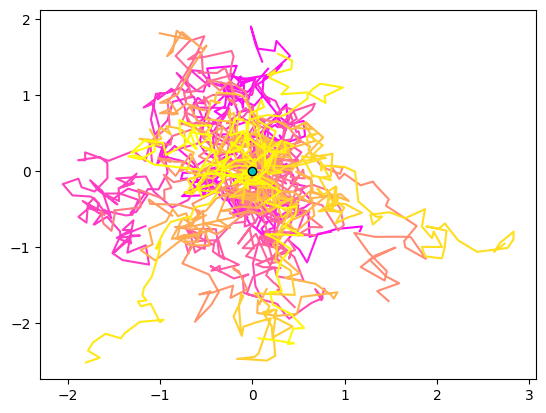

In [14]:
forward_brownian_motion_trajectories = model.simulate_forward_process(initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)))
print(forward_brownian_motion_trajectories.shape)
colormap = plt.get_cmap("spring")
colors = [colormap(i) for i in jnp.linspace(0, 1, forward_brownian_motion_trajectories.shape[0])]
for i in range(forward_brownian_motion_trajectories.shape[0]):
    plt.plot(forward_brownian_motion_trajectories[i, :, 0], forward_brownian_motion_trajectories[i, :, 1], color=colors[i])
plt.scatter(forward_brownian_motion_trajectories[0, 0, 0], forward_brownian_motion_trajectories[0, 0, 1], color='c', edgecolor='k', zorder=2)

(32, 51, 2)


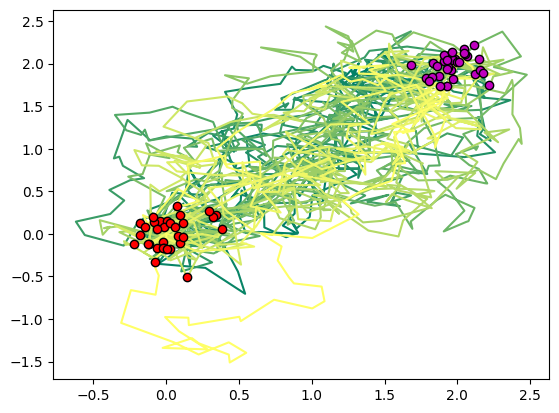

In [15]:
backward_brownian_bridge_trajectories = model.simulate_backward_bridge(score_transition_net=score_transition_net, 
                                                                       score_transition_net_params=score_transition_params, 
                                                                       initial_condition=jnp.tile(jnp.array([[2.0, 2.0]]), reps=(32, 1)), 
                                                                       terminal_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                                       using_true_score=False)
print(backward_brownian_bridge_trajectories.shape)
colormap = plt.get_cmap("summer")
colors = [colormap(i) for i in jnp.linspace(0, 1, backward_brownian_bridge_trajectories.shape[0])]
for i in range(backward_brownian_bridge_trajectories.shape[0]):
    plt.plot(backward_brownian_bridge_trajectories[i, :, 0], backward_brownian_bridge_trajectories[i, :, 1], color=colors[i], zorder=1)
    plt.scatter(backward_brownian_bridge_trajectories[i, 1, 0], backward_brownian_bridge_trajectories[i, 1, 1], color='r', edgecolor='k', zorder=2)
    plt.scatter(backward_brownian_bridge_trajectories[i, -2, 0], backward_brownian_bridge_trajectories[i, -2, 1], color='m', edgecolor='k', zorder=2)

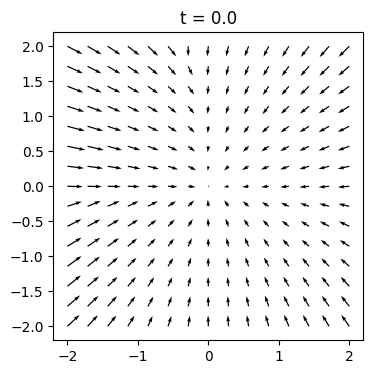

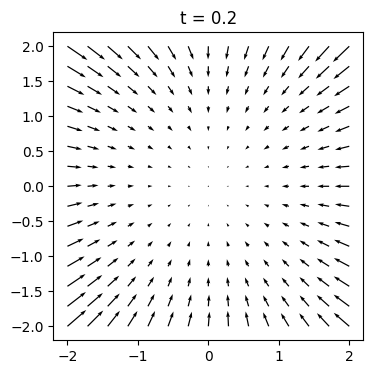

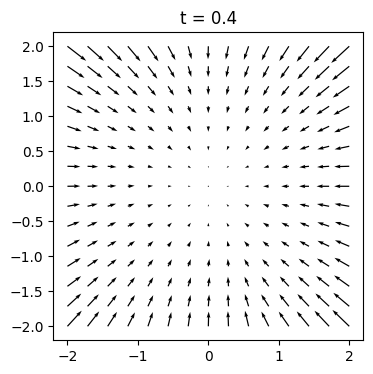

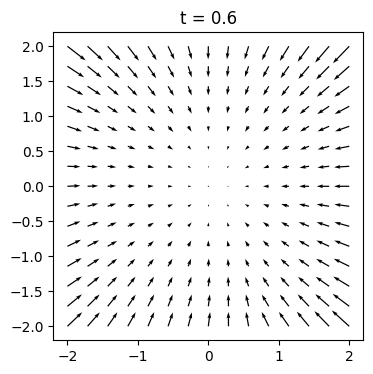

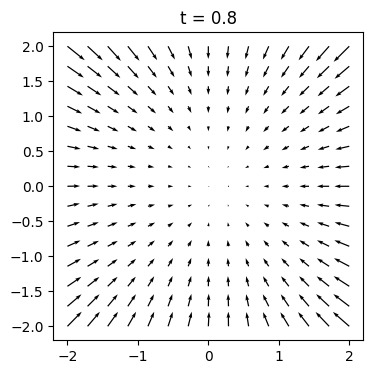

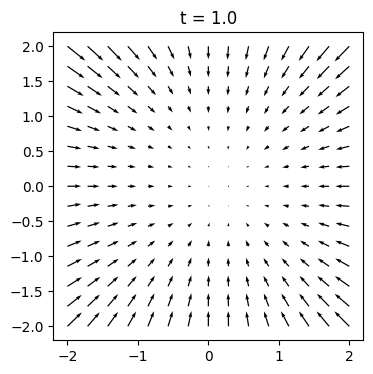

In [16]:
for t in jnp.linspace(0., 1., 5+1):
    plot_est_vector_field(score_transition_net, 
                          score_transition_params,
                          xs=jnp.linspace(-2.0, 2.0, 15),
                          t=t)

In [17]:
train_params = {"batch_size": 64, "num_epochs": 20, "num_batches_per_epoch": 50, "learning_rate": 1e-2}
score_marginal_net = ScoreNet(out_dim=model.d)
score_marginal_params = model.learn_marginal_score(score_marginal_net=score_marginal_net,
                                                   initial_condition=jnp.array([2.0, 2.0]),
                                                   terminal_condition=jnp.array([0.0, 0.0]),
                                                   score_transition_net=score_transition_net,
                                                   score_transition_params=score_transition_params,
                                                   training_params=train_params)

Epoch 0 / 20: loss = 50.3995
Epoch 1 / 20: loss = 49.4202
Epoch 2 / 20: loss = 49.2584
Epoch 3 / 20: loss = 49.1994
Epoch 4 / 20: loss = 49.2684
Epoch 5 / 20: loss = 49.1309
Epoch 6 / 20: loss = 49.0051
Epoch 7 / 20: loss = 49.0458
Epoch 8 / 20: loss = 48.4180
Epoch 9 / 20: loss = 48.4439
Epoch 10 / 20: loss = 48.6393
Epoch 11 / 20: loss = 48.4586
Epoch 12 / 20: loss = 48.5610
Epoch 13 / 20: loss = 48.4297
Epoch 14 / 20: loss = 48.4464
Epoch 15 / 20: loss = 48.4526
Epoch 16 / 20: loss = 48.4232
Epoch 17 / 20: loss = 48.4082
Epoch 18 / 20: loss = 48.6501
Epoch 19 / 20: loss = 48.4024


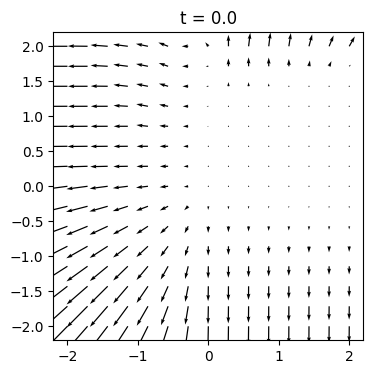

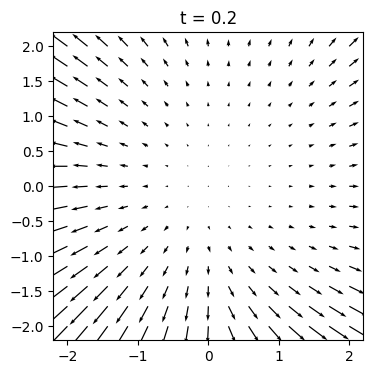

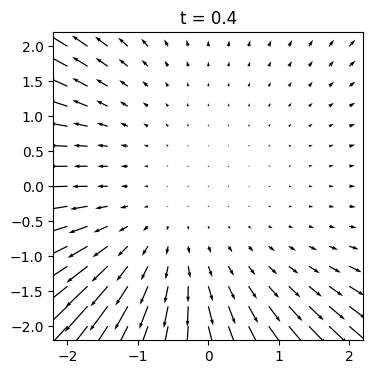

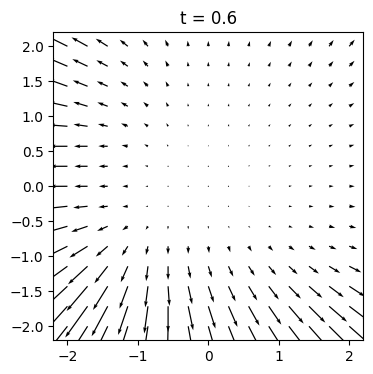

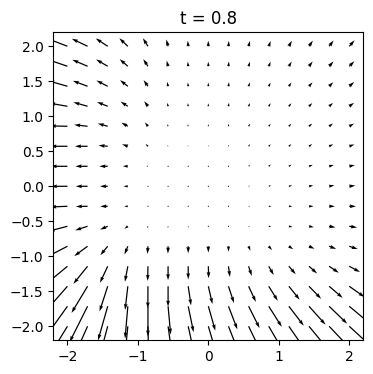

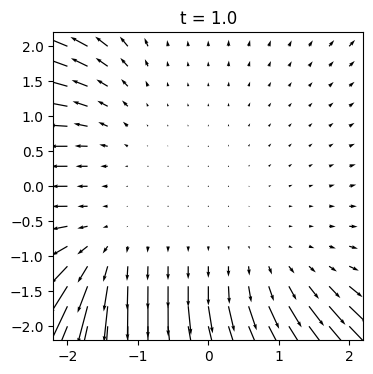

In [18]:
for t in jnp.linspace(0., 1., 5+1):
    plot_est_vector_field(score_marginal_net, 
                          score_marginal_params,
                          xs=jnp.linspace(-2.0, 2.0, 15),
                          t=t)

(32, 51, 2)


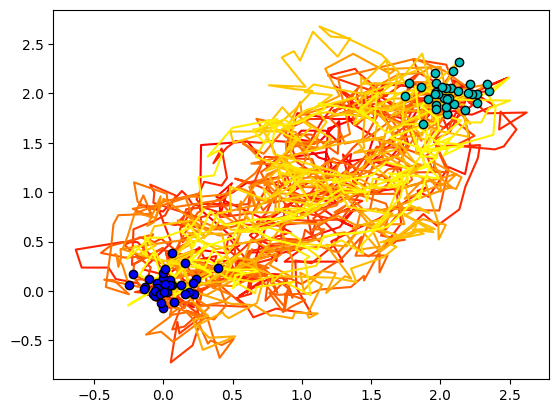

In [224]:
forward_brownian_bridge_trajectories = model.simulate_forward_bridge(score_transition_net=score_transition_net,
                                                                     score_transition_params=score_transition_params, 
                                                                     score_marginal_net=score_marginal_net,
                                                                     score_marginal_params=score_marginal_params,
                                                                     initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                                     terminal_condition=jnp.tile(jnp.array([[2.0, 2.0]]), reps=(32, 1)), 
                                                                     using_true_score=True)
print(forward_brownian_bridge_trajectories.shape)
colormap = plt.get_cmap("autumn")
colors = [colormap(i) for i in jnp.linspace(0, 1, forward_brownian_bridge_trajectories.shape[0])]
for i in range(forward_brownian_bridge_trajectories.shape[0]):
    plt.plot(forward_brownian_bridge_trajectories[i, :, 0], forward_brownian_bridge_trajectories[i, :, 1], color=colors[i], zorder=1)
    plt.scatter(forward_brownian_bridge_trajectories[i, 1, 0], forward_brownian_bridge_trajectories[i, 1, 1], color='b', edgecolor='k', zorder=2)
    plt.scatter(forward_brownian_bridge_trajectories[i, -2, 0], forward_brownian_bridge_trajectories[i, -2, 1], color='c', edgecolor='k', zorder=2)


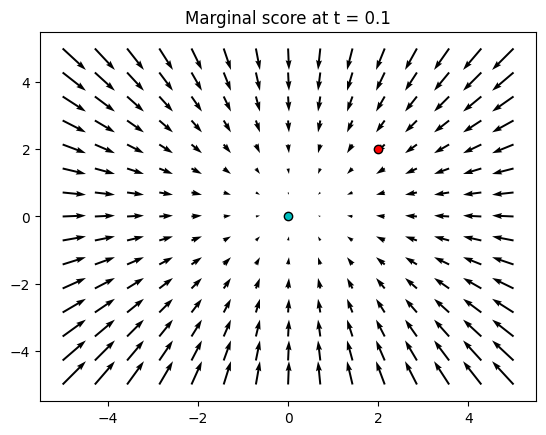

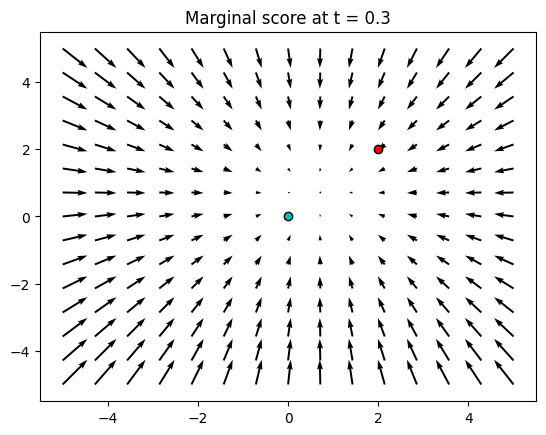

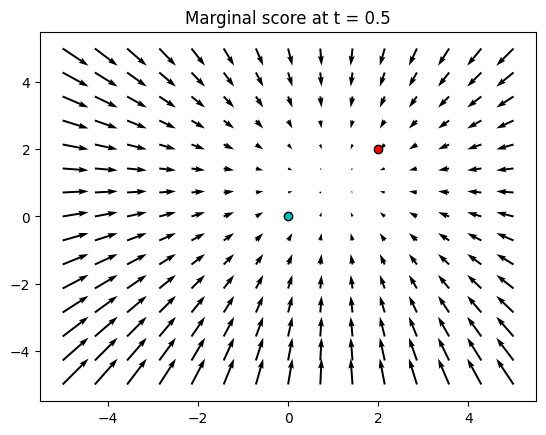

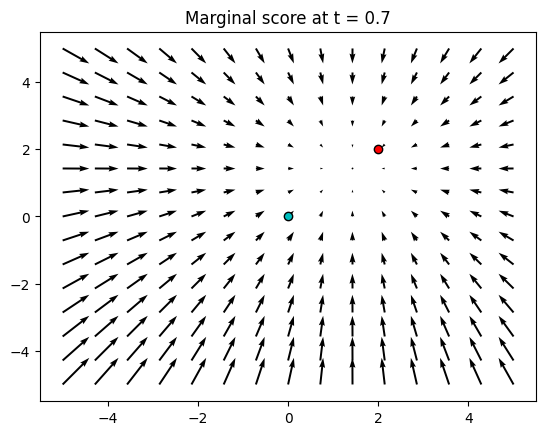

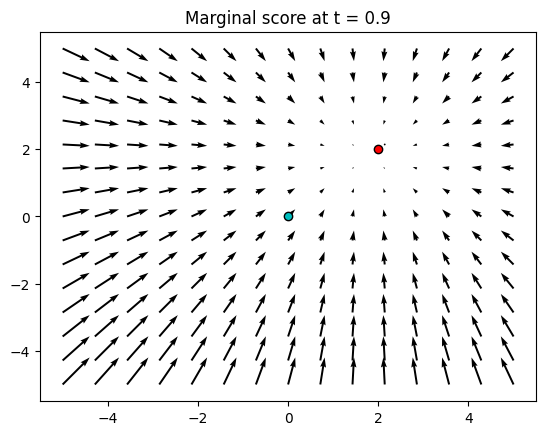

In [227]:
score_h = lambda x, xT, t, T: -(x - xT) / (T - t)
score_p = lambda x, x0, t, T: -(x - x0) / t
score_p_star = lambda x, x0, xT, t, T: score_h(x, xT, t, T) + score_p(x, x0, t, T)
x0 = jnp.array([0.0, 0.0])
xT = jnp.array([2.0, 2.0])
T = 1.0

def plot_vector_field(X: callable, t: float, xs: jnp.ndarray):
    xm, ym = jnp.meshgrid(xs, xs)
    x = jnp.stack([xm.flatten(), ym.flatten()], axis=-1)
    score_field = jax.vmap(X, in_axes=(0, None, None, None, None))(x, x0, xT, t, T)
    u = score_field[:, 0].reshape(xm.shape)
    v = score_field[:, 1].reshape(xm.shape)
    fig, ax = plt.subplots()
    ax.quiver(xm, ym, u, v)
    ax.set_title(f"Marginal score at t = {t:.1f}")
    ax.scatter(x0[0], x0[1], color='c', edgecolor='k', zorder=2)
    ax.scatter(xT[0], xT[1], color='r', edgecolor='k', zorder=2)
    plt.show()

for t in jnp.linspace(0.1, 0.9, 5):
    plot_vector_field(score_p_star, t, xs=jnp.linspace(-5.0, 5.0, 15))
